## CS536: Perceptrons
#### Done by - Vedant Choudhary, vc389
In the usual way, we need data that we can fit and analyze using perceptrons. Consider generating data points (X, Y) in the following way:
- For $i = 1,....,k-1$, let $X_i ~ N(0, 1)$ (i.e. each $X_i$ is an i.i.d. standard normal)
- For $i = k$, generate $X_k$ in the following way: let $D ~ Exp(1)$, and for a parameter $\epsilon > 0$ take

$X_k = (\epsilon + D)$ with probability 1/2

$X_k = -(\epsilon + D)$ with probability 1/2

The effect of this is that while $X_1,...X_{k-1}$ are i.i.d. standard normals, $X_k$ is distributed randomly with some gap (of size $2\epsilon$ around $X_k = 0$. We can then classify each point according to the following:

$Y = 1$ if $X_k$ > 0

$Y = -1$ if $X_k$ < 0

We see that the class of each data point is determined entirely by the value of the $X_k$ feature

#### 1. Show that there is a perceptron that correctly classifies this data. Is this perceptron unique? What is the ‘best’ perceptron for this data set, theoretically?

**Solution:** The perceptron generated when the data is linearly separable is unique. Best perceptron for a data would be the perceptron that relies heaviliy on the last feature of the dataset, as target value is governed by that.

In [74]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from tqdm import tqdm

%matplotlib inline

In [75]:
# Creating X (feature) vectors for the data
def create_data(k, m, D, epsilon):
    X_k_minus_1 = np.random.normal(0, 1, (m,k-1))
    X_k = []
    for i in range(m):
        temp = np.random.choice(2, 1, p=[0.5,0.5])
#         print(temp)
        if temp == 1:
            X_k.append(epsilon + D)
        else:
            X_k.append(-(epsilon + D))
    X_k = np.asarray(X_k).reshape((1,m))
#     print(X_k_minus_1)
#     print(X_k)
    return np.concatenate((X_k_minus_1, X_k.T), axis=1)

# Creating target column for the data
def create_y(X, m):
    y = []
    for i in range(m):
        if X[i][-1] > 0:
            y.append(1)
        else:
            y.append(-1)
    return y

# Combining all the sub data points into a dataframe
def create_dataset(k, m, epsilon, D):
    X = np.asarray(create_data(k, m, epsilon, D))
    y = np.asarray(create_y(X, m)).reshape((m,1))
#     print(X.shape,y.shape)

    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(1,k+1)]+['Y'])
    return data

In [151]:
# Global Variables - k = 20, m = 100, epsilon = 1
k, m, epsilon = 20, 100, 1
D = float(np.random.exponential(1, 1))

train_data = create_dataset(k, m, epsilon, D)
train_data.head()

#### 2. We want to consider the problem of learning perceptrons from data sets. Generate a set of data of size m = 100 with k = 20, $\epsilon$ = 1
##### -  Implement the perceptron learning algorithm. This data is separable, so the algorithm will terminate. How does the output perceptron compare to your theoretical answer in the previous problem?

In [77]:
# Class for Perceptron
class Perceptron():
    def __init__(self):
        pass
    
    def sign_function(self, data_vec):
        return np.array([1 if val >= 1 else -1 for val in data_vec])[:, np.newaxis]
    
    def pla(self, data):
        X = np.asarray(data.iloc[:,:-1])
        y = np.asarray(data.iloc[:,-1:])
        num_samples, num_features = X.shape
        
#         Initialize weight and bias parameters
        self.w = np.zeros(shape=(num_features, 1))
        self.bias = 0
        
        count_till_solution = 0
        f_x = [0]*num_samples
        i = 0
        theoretical_termination = []
        while True:
            mismatch = 0
            for i in range(num_samples):
#                 Calculate the mapping function f(x)
                f_x[i] = float(self.sign_function(np.dot(X[i].reshape((num_features, 1)).T, self.w) + self.bias))

#                 Compute weights if f_x != y
                if float(f_x[i]) != float(y[i]):
                    mismatch += 1
                    self.w += np.dot(X[i].reshape((num_features, 1)), y[i].reshape((1,1)))
                    self.bias += y[i]
                    
            count_till_solution += 1
            min_margin = 99999
            for i in range(num_samples):
                margin = abs(np.dot(self.w.T, X[i].reshape(-1,1))/(np.linalg.norm(self.w)))
                if margin < min_margin:
                    min_margin = margin
                
            theoretical_termination.append(int(1/(min_margin**2)))
            
            f_x = np.asarray(f_x).reshape((num_samples, 1))
            i += 1
            if (np.array_equal(y, f_x)) or (mismatch >= 0.3*num_samples and count_till_solution >= 5000):
                break
                    
        return self.w, self.bias, count_till_solution, max(theoretical_termination)
    
    '''
    Predicts the target value based on a data vector
    Input - a single row of dataset or a single X vector
    Return - predicted value
    '''
    def predict(self, instance_data):
        instance_data = np.asarray(instance_data)
        prediction = self.sign_function(np.dot(self.w.T, instance_data.reshape((len(instance_data),1))) + self.bias)
        return prediction   
    
    '''
    Predicts the target value and then calculates error based on the predictions
    Input - dataset, decision tree built
    Return - error
    '''
    def fit(self, data):
        error = 0
        for i in range(len(data)):
            prediction = self.predict(data.iloc[i][:-1])
            if prediction != data.iloc[i][-1]:
                print("Not equal")
                error += 1
        return error/len(data) 

In [78]:
perceptron = Perceptron()
final_w, final_b, num_steps, theoretical_steps = perceptron.pla(train_data)
print("Final weights:\n",final_w)
print("Final bias:\n", final_b)
print("Number of steps till convergence: \n", num_steps)
print("Theoretical number of steps till convergence can be found for linear separation: ", theoretical_steps)

Final weights:
 [[-0.02028282]
 [ 0.49567837]
 [ 1.65992916]
 [ 1.39967994]
 [-1.21313692]
 [ 0.41967402]
 [ 1.38417544]
 [-0.34832315]
 [-0.97126667]
 [-1.27272908]
 [ 0.71416946]
 [-0.23664319]
 [ 0.66668559]
 [ 1.19579859]
 [ 0.41361097]
 [ 0.31351518]
 [ 1.32944018]
 [ 1.12600237]
 [ 0.86236847]
 [ 7.91628015]]
Final bias:
 [2.]
Number of steps till convergence: 
 2
Theoretical number of steps till convergence can be found for linear separation:  3


In [79]:
error = perceptron.fit(train_data)
error

0.0

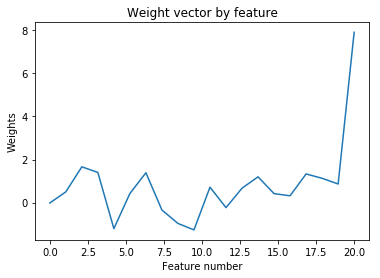

In [155]:
plt.plot(np.linspace(0, 20, 20), list(final_w))
plt.title("Weight vector by feature")
plt.xlabel("Feature number")
plt.ylabel("Weights")
plt.show()

**Solution:** On implementing the perceptron learning algorithm on the dataset provided, we see that it is similar to our theoretical answer. The last feature has highest weight associated to it (as can be seen from the graph generated above). This is so because the data is created such that the target value depends solely on the last feature value.

#### 3. For any given data set, there may be multiple separators with multiple margins - but for our data set, we can effectively control the size of the margin with the parameter $\epsilon$ - the bigger this value, the bigger the margin of our separator.
#### – For m = 100, k = 20, generate a data set for a given value of $\epsilon$ and run the learning algorithm to completion. Plot, as a function of $\epsilon$ ∈ [0, 1], the average or typical number of steps the algorithm needs to terminate. Characterize the dependence.

In [80]:
def varied_margin():
    k, m = 20, 100
    epsilon = list(np.arange(0, 1.05, 0.05))
    avg_steps = []
    for i in tqdm(range(len(epsilon))):
        steps = []
        for j in range(100):
            train_data = create_dataset(k, m, epsilon[i], D)
            perceptron = Perceptron()
            final_w, final_b, num_steps, theoretical_steps = perceptron.pla(train_data)
            steps.append(num_steps)
          
        avg_steps.append(sum(steps)/len(steps))
        
    plt.plot(epsilon, avg_steps)
    plt.title("Number of steps w.r.t. margin")
    plt.xlabel("Margin value")
    plt.ylabel("#Steps")
    plt.show()

100%|██████████| 21/21 [00:18<00:00,  1.19it/s]


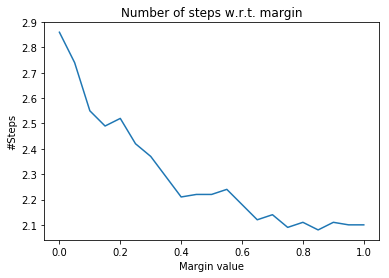

In [81]:
varied_margin()

**Solution:** On plotting average number of steps needed for termination of a linearly separable data w.r.t. $\epsilon$, we observe that bigger the margin, lesser the number of steps are needed for the perceptron to terminate. This dependence can be proved by the Perceptron Convergence Theorem - If data is linearly separable, perceptron algorithm will find a linear classifier that classifies all data correctly, whose convergence is inversely proportional to the square of margin.

This means as the margin increases, the convergence steps decrease.

#### 4. One of the nice properties of the perceptron learning algorithm (and perceptrons generally) is that learning the weight vector w and bias value b is typically independent of the ambient dimension. To see this, consider the following experiment:
#### – Fixing m = 100, $\epsilon$ = 1, consider generating a data set on k features and running the learning algorithm on it. Plot, as a function k (for k = 2, . . . , 40), the typical number of steps to learn a perceptron on a data set of this size. How does the number of steps vary with k? Repeat for m = 1000.

In [88]:
def varied_features(m):
    epsilon = 1
    D = float(np.random.exponential(1, 1))
    k = list(np.arange(2, 40, 1))
    steps = []
    for i in range(len(k)):
        train_data = create_dataset(k[i], m, epsilon, D)
        perceptron = Perceptron()
        final_w, final_b, num_steps, theoretical_steps = perceptron.pla(train_data)
        steps.append(num_steps)
        
    plt.plot(k, steps)
    plt.title("Number of steps w.r.t. features")
    plt.xlabel("#Features")
    plt.ylabel("#Steps")
    plt.show()

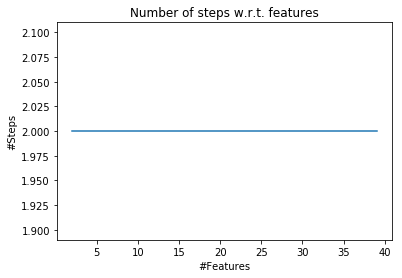

In [91]:
varied_features(100)

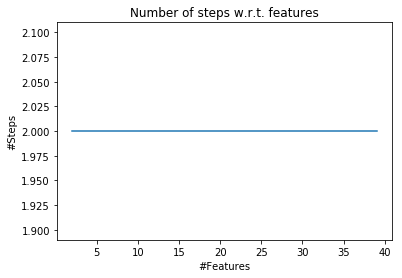

In [92]:
varied_features(1000)

**Solution:** The number of steps needed for convergence of a linearly separable data through perceptrons is usually independent of number of features the data has. This is shown through the above experiment too. For this case, I see no change in number of steps, but some different runs have shown very random change in number of steps, that also by just 1 step more or less. We cannot establish a trend of convergence w.r.t. the number of features.

#### 5. As shown in class, the perceptron learning algorithm always terminates in finite time - if there is a separator. Consider generating non-separable data in the following way: generate each $X_1, . . . , X_k$ as i.i.d. standard normals N(0, 1). Define Y by

$$Y = 1 if \sum_{i=1}^k{X_i^2} \ge k $$
$$Y = -1 else$$

In [93]:
def create_non_separable_data(k, m):
    X = np.random.normal(0, 1, (m,k))
    y = []
    for i in range(m):
        total = 0
        for j in range(k):
            total += X[i][j]**2
        
        if total >= k:
            y.append(1)
        else:
            y.append(-1)
            
    return X, y

def create_non_separable_dataset(k, m):
    X, y = create_non_separable_data(k, m)
    X = np.asarray(X)
    y = np.asarray(y).reshape((m,1))
    # Training data is an appended version of X and y arrays
    data = pd.DataFrame(np.append(X, y, axis=1), columns=["X" + str(i) for i in range(1,k+1)]+['Y'])
    return data

In [94]:
k, m = 2, 100
train_ns_data = create_non_separable_dataset(k, m)
train_ns_data.head()

,X1,X2,Y
0,0.475437,-0.333426,-1.0
1,-1.860030,-0.038617,1.0
2,0.130696,-1.140265,-1.0
3,-0.595984,-0.566819,-1.0
4,-0.144487,0.682837,-1.0


In [95]:
perceptron2 = Perceptron()
final_w2, final_b2, num_steps2, theoretical_steps = perceptron2.pla(train_ns_data)

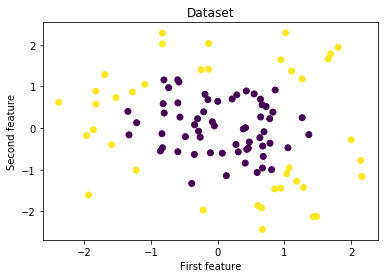

In [136]:
plt.scatter(X1, X2, c=y2)
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

In [158]:
def plot_hyperplane(x1, x2, y, w, b):
    slope = -w[0]/w[1]
    intercept = -b/w[1]
    x_hyperplane = np.linspace(-3,3,20)
    y_hyperplane = slope*x_hyperplane + intercept
    plt.scatter(x1, x2, c=y)
    plt.plot(x_hyperplane, y_hyperplane, 'b-')
    plt.title("Dataset with fitted hyperplane")
    plt.xlabel("First feature")
    plt.ylabel("Second feature")
    plt.show()

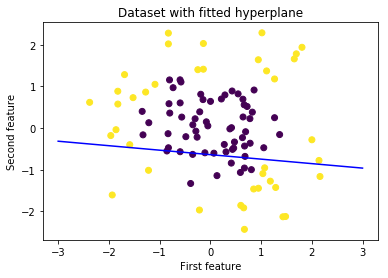

In [159]:
X2_1 = train_ns_data.iloc[:,:-2]
X2_2 = train_ns_data.iloc[:,1:-1]
y2 = train_ns_data.iloc[:,-1:]
plot_hyperplane(X2_1, X2_2, y2, final_w2, final_b2)

**Solution:** For a linearly non-separable data, perceptron is not a good algorithm to use, because it will never converge. Theoretically, it is possible to find an upper bound on number of steps required to converge (if the data is linearly separable). But, it cannot be put into practice easily, as to compute that, we first need to find the weight vector. 

Another thing to note is that, even if there is a convergence, the number of steps needed might be too large, which might bring the problem of computation power.

For this assignment, I have established a heurisitc that if the mismatch % is approximately 30% of the total number of samples and the iterations have been more than 10000, then that means that possibly the data is not separable linearly. My reasoning for this is very straight forward, if 30% of data is still mismatched, it is likely that the mismatch will continue to happen for long, which is not computationally feasible.